In [1]:
!pip install pmdarima


     |████████████████████████████████| 1.5MB 5.5MB/s 
     |████████████████████████████████| 9.5MB 18.2MB/s 
     |████████████████████████████████| 2.1MB 45.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.22
    Uninstalling Cython-0.29.22:
      Successfully uninstalled Cython-0.29.22


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima

%matplotlib inline

In [7]:
df=pd.read_csv("MyFridge.csv",header=0,infer_datetime_format=True,parse_dates=['occurtime'])


In [8]:
df.head()


,occurtime,power
0,2020-12-10_00:05:00,130.16
1,2020-12-10_00:10:00,124.64
2,2020-12-10_00:15:00,121.36
3,2020-12-10_00:20:00,120.16
4,2020-12-10_00:25:00,0.00


In [10]:
df['occurtime'] = pd.to_datetime(df['occurtime'],format="%Y-%m-%d_%H:%M:%S")


In [11]:
df.to_csv('fridge.csv',index=False,date_format="%Y-%m-%d %H:%M:%S")


In [12]:
df=pd.read_csv("fridge.csv",header=0,infer_datetime_format=True,parse_dates=['occurtime'],index_col=['occurtime'])


In [13]:
hourly_data=df.resample('H').sum()


In [14]:
hourly_data.head()

,power
occurtime,
2020-12-10 00:00:00,882.56
2020-12-10 01:00:00,873.44
2020-12-10 02:00:00,897.76
2020-12-10 03:00:00,1310.64
2020-12-10 04:00:00,1521.35


In [15]:
hourly_data.describe()


,power
count,408.000000
mean,867.505515
std,269.873470
min,0.000000
25%,729.180000
50%,859.960000
75%,993.440000
max,1837.540000


In [16]:
hourly_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 408 entries, 2020-12-10 00:00:00 to 2020-12-26 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   power   408 non-null    float64
dtypes: float64(1)
memory usage: 6.4 KB


**visualization**

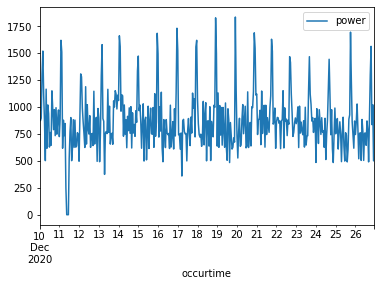

In [17]:
hourly_data.plot()

**stationarity test**

In [18]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(hourly_data['power'])

In [19]:
#H1: It is stationary

def adfuller_test(consumption):
    result=adfuller(consumption)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [20]:
adfuller_test(hourly_data['power'])


ADF Test Statistic : -14.039226703093547
p-value : 3.326538911040085e-26
#Lags Used : 0
Number of Observations Used : 407
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [21]:
import warnings
warnings.filterwarnings('ignore')

**arima**

In [24]:
stepwise_fit=auto_arima(hourly_data['power'].dropna(),trace=True,supress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=5684.718, Time=1.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=5728.782, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=5679.247, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=5686.895, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=6718.203, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=5680.400, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=5680.739, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=5682.394, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5830.206, Time=0.03 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.797 seconds


In [25]:
stepwise_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  408
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -2836.623
Date:                Fri, 16 Apr 2021   AIC                           5679.247
Time:                        19:53:23   BIC                           5691.280
Sample:                             0   HQIC                          5684.008
                                - 408                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    568.3117     38.543     14.745      0.000     492.769     643.855
ar.L1          0.3450      0.040      8.609      0.000       0.266       0.424
sigma2      6.417e+04   3837.720     16.721      0.000    5.66e+04    7.17e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                66.02
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.71
Prob(H) (two-sided):                  0.05   Kurtosis:                         4.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [26]:
from statsmodels.tsa.arima_model import ARIMA


In [28]:
408*.7


285.59999999999997

In [29]:
train=hourly_data.iloc[:285]
test=hourly_data.iloc[285:]
print(train.shape,test.shape)

(285, 1) (123, 1)


In [30]:
print(train.shape,test.shape)

(285, 1) (123, 1)


In [31]:
model=ARIMA(train['power'].dropna(),order=(1,0,0))
model=model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  power   No. Observations:                  285
Model:                     ARMA(1, 0)   Log Likelihood               -1998.402
Method:                       css-mle   S.D. of innovations            268.480
Date:                Fri, 16 Apr 2021   AIC                           4002.805
Time:                        20:01:10   BIC                           4013.762
Sample:                    12-10-2020   HQIC                          4007.197
                         - 12-21-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         875.4642     24.280     36.057      0.000     827.876     923.052
ar.L1.power     0.3462      0.055      6.247      0.000       0.238       0.455
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.8884           +0.0000j            2.8884            0.0000
-----------------------------------------------------------------------------
"""

In [32]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
print(pred)

2020-12-21 21:00:00    863.961478
2020-12-21 22:00:00    871.481803
2020-12-21 23:00:00    874.085461
2020-12-22 00:00:00    874.986889
2020-12-22 01:00:00    875.298978
                          ...    
2020-12-26 19:00:00    875.464247
2020-12-26 20:00:00    875.464247
2020-12-26 21:00:00    875.464247
2020-12-26 22:00:00    875.464247
2020-12-26 23:00:00    875.464247
Freq: H, Length: 123, dtype: float64


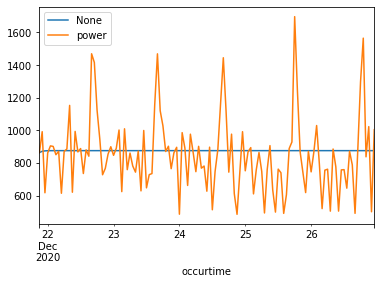

In [33]:
pred.plot(legend=True)
test['power'].plot(legend=True)

In [34]:
test['power'].mean()


848.9476422764229

In [35]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['power']))
print(rmse)

226.41282230912128


In [37]:
model2=ARIMA(hourly_data['power'],order=(1,0,0))
model2=model2.fit()
hourly_data.tail()

,power
occurtime,
2020-12-26 19:00:00,1565.17
2020-12-26 20:00:00,837.60
2020-12-26 21:00:00,1022.72
2020-12-26 22:00:00,500.80
2020-12-26 23:00:00,1004.00


In [38]:
index_future_dates=pd.date_range(start='2020-12-26 23:00:00',end='2021-01-05 23:00:00')
pred=model2.predict(start=len(hourly_data),end=len(hourly_data)+10,typ='levels').rename('arima preds')
pred.index=index_future_dates
print(pred)

2020-12-26 23:00:00    914.602479
2020-12-27 23:00:00    883.837222
2020-12-28 23:00:00    873.249668
2020-12-29 23:00:00    869.606068
2020-12-30 23:00:00    868.352159
2020-12-31 23:00:00    867.920639
2021-01-01 23:00:00    867.772136
2021-01-02 23:00:00    867.721030
2021-01-03 23:00:00    867.703443
2021-01-04 23:00:00    867.697390
2021-01-05 23:00:00    867.695307
Freq: D, Name: arima preds, dtype: float64


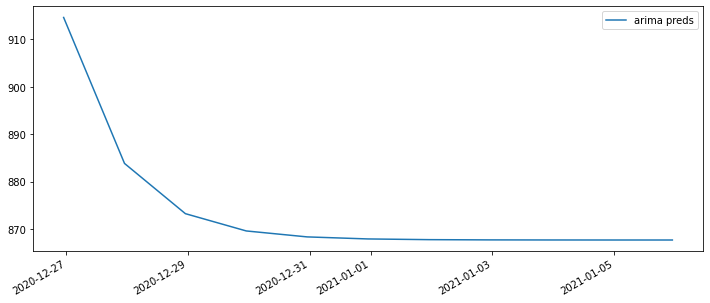

In [39]:
pred.plot(figsize=(12,5),legend=True)


**outliers** **removed**

In [40]:
from numpy.random import seed
from numpy.random import randn
from numpy import mean
from numpy import std
data_mean, data_std = mean(hourly_data['power']), std(hourly_data['power'])
print(data_mean,data_std)

867.5055147058823 269.5425393720026


In [46]:
# identify outliers
#std = 1
cut_off = data_std * 1
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower,upper)
# number of outliers and their vals outliers
outliers = [x for x in hourly_data['power'] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
print(outliers)
hourly_data_filtered=hourly_data[(hourly_data.power>=lower)&(hourly_data.power<=upper)]
hourly_data_filtered.shape

597.9629753338797 1137.048054077885
Identified outliers: 79
[1310.64, 1521.35, 502.64, 1167.12, 1151.52, 1621.4499999999998, 1512.24, 249.76, 0.0, 0.0, 0.0, 520.56, 502.24, 497.28000000000003, 1309.04, 1281.33, 1189.9199999999998, 1147.8400000000001, 496.0, 492.56, 1288.3099999999997, 1581.04, 374.96, 1165.76, 1153.28, 1663.28, 1563.7599999999998, 1337.1200000000001, 1474.9199999999998, 498.88, 509.76, 1686.5199999999998, 1495.68, 1138.8000000000002, 492.15999999999997, 1733.4799999999996, 1524.48, 359.6, 500.16, 1559.3899999999999, 1621.3600000000001, 500.88, 503.6, 1830.08, 1499.3600000000001, 506.08000000000004, 484.8, 1837.54, 1149.44, 527.28, 1142.1599999999999, 1143.76, 1690.8600000000001, 1547.1999999999998, 1149.76, 1631.3399999999997, 1520.24, 1152.8799999999999, 1469.44, 1416.28, 1155.52, 1469.0, 485.84, 512.96, 1163.92, 1444.9699999999998, 485.12000000000006, 493.36, 498.72, 490.88, 1696.9800000000002, 1243.44, 520.0, 504.56000000000006, 504.79999999999995, 491.0399999999999

(329, 1)

In [44]:
from scipy import stats
z_scores = stats.zscore(hourly_data)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = hourly_data[filtered_entries]

print(new_df)

                       power
occurtime                   
2020-12-10 00:00:00   882.56
2020-12-10 01:00:00   873.44
2020-12-10 02:00:00   897.76
2020-12-10 03:00:00  1310.64
2020-12-10 04:00:00  1521.35
...                      ...
2020-12-26 19:00:00  1565.17
2020-12-26 20:00:00   837.60
2020-12-26 21:00:00  1022.72
2020-12-26 22:00:00   500.80
2020-12-26 23:00:00  1004.00

[399 rows x 1 columns]


In [45]:
408-399

9

**stationarity for outliers**

In [63]:
adfuller_test(new_df['power'])


ADF Test Statistic : -11.223795396845421
p-value : 1.9834565059770225e-20
#Lags Used : 1
Number of Observations Used : 397
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [52]:
399*.7


279.29999999999995

In [48]:
adfuller_test(hourly_data_filtered['power'])


ADF Test Statistic : -11.004284278000666
p-value : 6.563448670768958e-20
#Lags Used : 1
Number of Observations Used : 327
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [64]:
stepwise_fit=auto_arima(hourly_data_filtered['power'].dropna(),trace=True,supress_warnings=True)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=4185.607, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4190.766, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4190.388, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4191.019, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5368.683, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=4183.681, Time=0.16 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=4181.799, Time=0.17 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=4183.693, Time=0.35 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4193.557, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=4185.713, Time=0.21 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4874.407, Time=0.25 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 1.723 seconds


In [67]:
n_train=hourly_data.iloc[:230]
n_test=hourly_data.iloc[230:]
print(n_train.shape,n_test.shape)

(230, 1) (178, 1)


In [66]:
329*.7


230.29999999999998

In [68]:
n_model=ARIMA(n_train['power'].dropna(),order=(0,0,2))
n_model=n_model.fit()
n_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  power   No. Observations:                  230
Model:                     ARMA(0, 2)   Log Likelihood               -1612.196
Method:                       css-mle   S.D. of innovations            267.834
Date:                Fri, 16 Apr 2021   AIC                           3232.391
Time:                        20:37:21   BIC                           3246.143
Sample:                    12-10-2020   HQIC                          3237.939
                         - 12-19-2020                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         867.0587     25.379     34.164      0.000     817.316     916.801
ma.L1.power     0.2950      0.065      4.542      0.000       0.168       0.422
ma.L2.power     0.1446      0.070      2.070      0.038       0.008       0.282
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.0199           -2.4239j            2.6297           -0.3134
MA.2           -1.0199           +2.4239j            2.6297            0.3134
-----------------------------------------------------------------------------
"""

In [69]:
n_start=len(n_train)
n_end=len(n_train)+len(n_test)-1
n_pred=n_model.predict(start=n_start,end=n_end,typ='levels')
print(n_pred)

2020-12-19 14:00:00    895.365857
2020-12-19 15:00:00    903.352970
2020-12-19 16:00:00    867.058728
2020-12-19 17:00:00    867.058728
2020-12-19 18:00:00    867.058728
                          ...    
2020-12-26 19:00:00    867.058728
2020-12-26 20:00:00    867.058728
2020-12-26 21:00:00    867.058728
2020-12-26 22:00:00    867.058728
2020-12-26 23:00:00    867.058728
Freq: H, Length: 178, dtype: float64


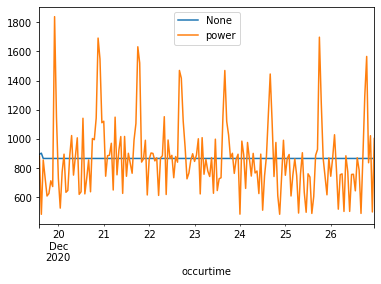

In [70]:
n_pred.plot(legend=True)
n_test['power'].plot(legend=True)

In [71]:
n_test['power'].mean()

868.5324719101123

In [72]:
n_rmse=sqrt(mean_squared_error(n_pred,n_test['power']))
print(n_rmse)

249.01862860471363
